In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from models.models import CNN, CNN_d
from torch.nn.utils import parameters_to_vector

# Set random seed for reproducibility
torch.manual_seed(42)

# Set device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform)


# Define the CNN + Dropout architecture with dropout and L2 regularization
class CNN_d(nn.Module):
    def __init__(self):
        super(CNN_d, self).__init__()
        # CNN layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.25)  # Added dropout
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.relu2 = nn.ReLU()
        self.pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(64 * 12 * 12, 128)
        self.relu3 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.5)  # Added dropout
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.dropout1(x)  # Added dropout
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.dropout2(x)  # Added dropout
        x = self.fc2(x)
        return x

# Define data loaders
batch_size = 64
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Create an instance of the CNN with L2 regularization
model = CNN_d().to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()

l2_lambda = 0.001  # L2 regularization lambda value
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=l2_lambda)

# Initialize lists to store the train and test losses for each epoch
train_losses = []
test_losses = []

num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        # L2 regularization
        l2_regularization = torch.tensor(0., device=device)
        for param in model.parameters():
            l2_regularization += torch.norm(param, 2)
        loss += l2_lambda * l2_regularization

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if (batch_idx + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    print(f'Train Accuracy: {(100 * correct / total):.2f}%')

    # Evaluation on the test set
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss /= len(test_loader)
    test_losses.append(test_loss)

    # Print test accuracy at the end of each epoch
    test_accuracy = (100 * correct / total)
    print(f'Test Accuracy: {test_accuracy:.2f}%')
    print(f'Test Loss: {test_loss:.4f}')


       


Epoch [1/30], Step [100/938], Loss: 0.3942
Epoch [1/30], Step [200/938], Loss: 0.1766
Epoch [1/30], Step [300/938], Loss: 0.2597
Epoch [1/30], Step [400/938], Loss: 0.2653
Epoch [1/30], Step [500/938], Loss: 0.4031
Epoch [1/30], Step [600/938], Loss: 0.1461
Epoch [1/30], Step [700/938], Loss: 0.2569
Epoch [1/30], Step [800/938], Loss: 0.2043
Epoch [1/30], Step [900/938], Loss: 0.1752
Train Accuracy: 92.27%
Test Accuracy: 97.71%
Test Loss: 0.0644
Epoch [2/30], Step [100/938], Loss: 0.0696
Epoch [2/30], Step [200/938], Loss: 0.0796
Epoch [2/30], Step [300/938], Loss: 0.1658
Epoch [2/30], Step [400/938], Loss: 0.2993
Epoch [2/30], Step [500/938], Loss: 0.1169
Epoch [2/30], Step [600/938], Loss: 0.1695
Epoch [2/30], Step [700/938], Loss: 0.1894
Epoch [2/30], Step [800/938], Loss: 0.2651
Epoch [2/30], Step [900/938], Loss: 0.0707
Train Accuracy: 96.51%
Test Accuracy: 98.58%
Test Loss: 0.0457
Epoch [3/30], Step [100/938], Loss: 0.0878
Epoch [3/30], Step [200/938], Loss: 0.2073
Epoch [3/30], 

Epoch [19/30], Step [200/938], Loss: 0.0318
Epoch [19/30], Step [300/938], Loss: 0.0429
Epoch [19/30], Step [400/938], Loss: 0.0516
Epoch [19/30], Step [500/938], Loss: 0.0592
Epoch [19/30], Step [600/938], Loss: 0.1207
Epoch [19/30], Step [700/938], Loss: 0.0370
Epoch [19/30], Step [800/938], Loss: 0.0982
Epoch [19/30], Step [900/938], Loss: 0.2115
Train Accuracy: 98.10%
Test Accuracy: 98.69%
Test Loss: 0.0390
Epoch [20/30], Step [100/938], Loss: 0.1096
Epoch [20/30], Step [200/938], Loss: 0.1275
Epoch [20/30], Step [300/938], Loss: 0.1677
Epoch [20/30], Step [400/938], Loss: 0.1407
Epoch [20/30], Step [500/938], Loss: 0.0380
Epoch [20/30], Step [600/938], Loss: 0.0457
Epoch [20/30], Step [700/938], Loss: 0.0757
Epoch [20/30], Step [800/938], Loss: 0.1132
Epoch [20/30], Step [900/938], Loss: 0.0624
Train Accuracy: 98.06%
Test Accuracy: 98.69%
Test Loss: 0.0370
Epoch [21/30], Step [100/938], Loss: 0.0444
Epoch [21/30], Step [200/938], Loss: 0.0735
Epoch [21/30], Step [300/938], Loss: 0

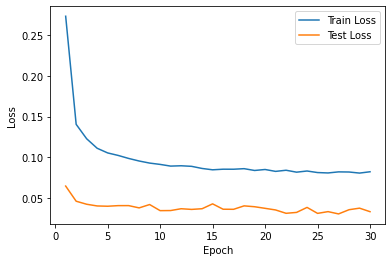

Confusion Matrix:
[[ 977    0    0    0    0    0    1    1    1    0]
 [   0 1127    1    2    1    1    1    1    1    0]
 [   2    0 1017    5    0    1    1    5    1    0]
 [   0    0    1 1006    0    1    0    0    2    0]
 [   0    0    0    0  972    0    3    0    3    4]
 [   2    0    0    7    0  875    4    1    2    1]
 [   3    2    0    0    1    2  949    0    1    0]
 [   0    3    4    3    0    1    0 1015    1    1]
 [   1    0    1    1    0    0    2    2  964    3]
 [   1    0    0    0    4    1    0    3    7  993]]


In [2]:
# Plot the train and test losses for each epoch
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Calculate and display the confusion matrix
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)